## **PhD Qualifying Examination: Data Science and Clinical Informatics**

**Romen Samuel Rodis Wabina** <br>
Student, PhD Data Science in Healthcare and Clinical Informatics <br>
Clinical Epidemiology and Biostatistics, Faculty of Medicine (Ramathibodi Hospital) <br>
Mahidol University

Note: In case of Python Markdown errors, you may access the assignment through this GitHub [Link](https://github.com/rrwabina/SkinLesionClassification/tree/main)

Let's import the relevant libraries for this task. In this notebook, we primarily utilized PyTorch as our library to develop our deep learning model. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torchvision
import time
import os
import copy
import PIL

from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image
from torchvision import datasets, models, transforms
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.metrics import f1_score, confusion_matrix, auc
from PIL import Image
from torch.utils.data import WeightedRandomSampler
from utils import visualize_cam, Normalize
from gradcam import GradCAM, GradCAMpp
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, classification_report

from collections import Counter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


The emergence of infectious diseases with pandemic potential has served as a wake-up call to various governments across the globe. Througout human history, the biological threat of a pandemic disease has been devastating on an unprecedented scale, as evidenced by diseases such as COVID-19, influenza, and the bubonic plague. Because of these risks, the rapid spread of the Monkeypox disease this year has posed another global threat during COVID-19 pandemic. The Monkeypox, primarily caused by the monkeypox virus, is an infectious zoonotic disease which is closely related to smallpox but with milder infection. The World Health Organization (WHO) already declared the Monkeypox outbreak an international public health emergency, citing with a staggering increase of 30,000 cases worldwide. While the WHO has not declared the monkeypox oubreak a pandemic, several epidemiologists have highlighted the severity of monkeypox disease infection among the human population.

# A. Data Exploration
**Questions 1-2. Conduct an exploratory data analysis on the dataset. Report the descriptive statistics with appropriate visualization. Explain why the selected visualization fits your purpose. Draw a block diagram to illustrate an overview of your experiment. Each block represents a task required in a deep learning experiement such as image processing, data augmentation, and data splitting.**

The image below shows an overview of the steps we employed in the experiment. First, we prepare the data by extracting its labels through its filenames. Once acquired, we fed our dataset into a data loader. The data loader serves as an input mechanism to the three types of deep learning models. In this experiment, we utilized seven models - including the BaselineCNN, derived from a modified AlexNet, three variants of Residual Networks with BottleNeck layers, and another three variants of Residuals Networks with Squeeze and Excitation Block. We also utilized Gradient-weighted Class Activation Mapping for model interpretability.

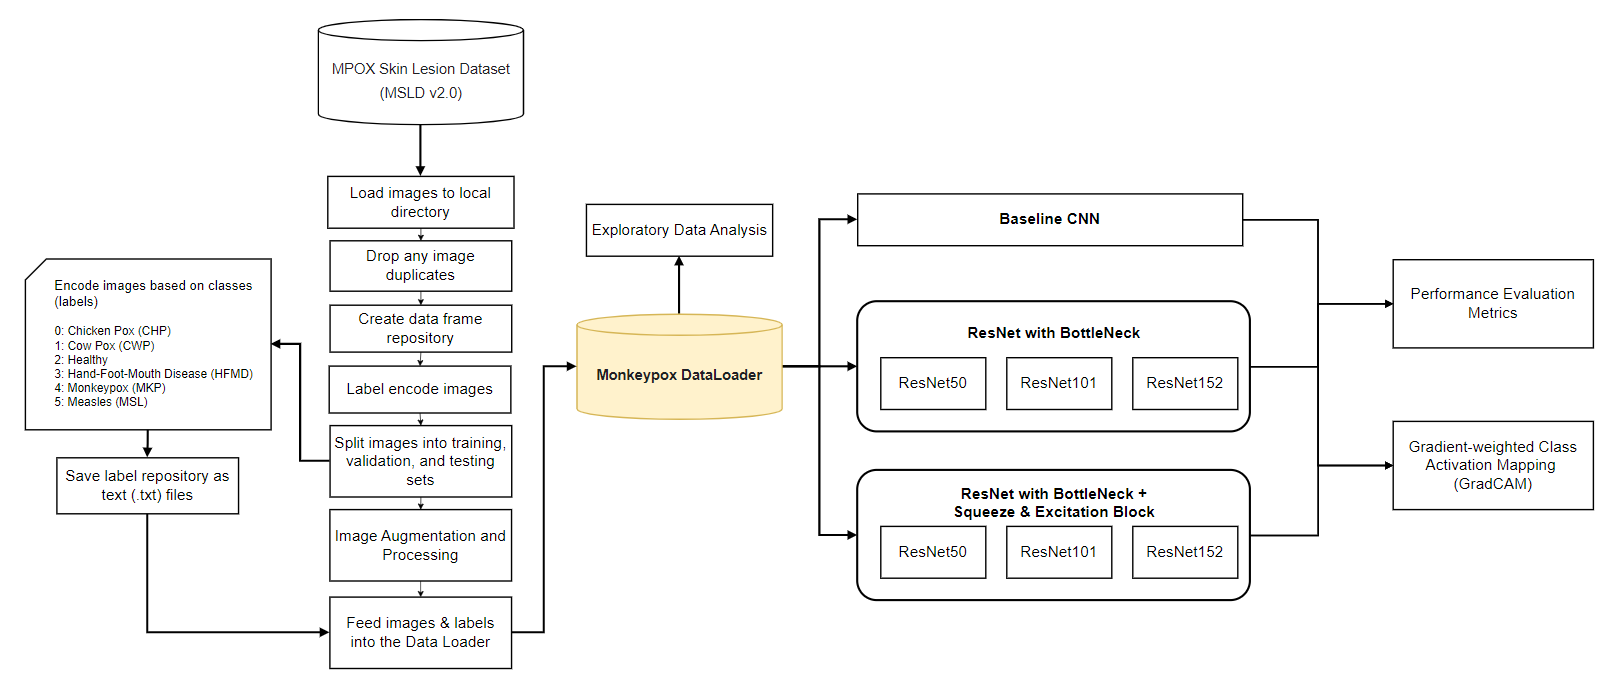

## A.1. Data Preparation
The MSLD v2.0 dataset comprises a total of 755 skin lesion images, distributed across six distinct classes. Specifically, these classes are as follows: monkeypox, consisting of 284 images; chickenpox, represented by 75 images; measles, with 55 images; coxpox, encompassing 66 images; hand-foot-mouth disease (HFMD), containing 161 images; and a healthy class, featuring 114 images. These 755 original skin lesion images were meticulously sourced from 541 unique patients, ensuring a representative sample.

We have meticulously organized these images in a dataframe repository, providing comprehensive information including the image filename and its respective local filepath. Our data curation process prioritized uniqueness and excluded any potential duplicates to prevent data leakage. Furthermore, we efficiently extracted the image labels from their filenames using the <code>os</code> function. Subsequently, these labels were encoded based on their corresponding classes, streamlining the dataset for analysis and classification purposes.

1. 0: Chicken Pox (CHP)
2. 1: Cox Pox (CWP)
3. 2: Healthy
4. 3: Hand-Foot-Mouth Disease (HFMD)
5. 4: Monkeypox (MKP)
6. 5: Measles (MSL)

In [3]:
folder_train, folder_valid, folder_tests = '/content/drive/MyDrive/QE_DataScience/data/images/train/', '/content/drive/MyDrive/QE_DataScience/data/images/valid/', '/content/drive/MyDrive/QE_DataScience/data/images/test/'

def get_images_path(folder):
    path_list = []
    image_files = [file for file in os.listdir(folder) if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png')]
    image_files = [path_list.append(folder + file) for file in image_files]
    return path_list
path_list_train, path_list_valid, path_list_tests = get_images_path(folder_train), get_images_path(folder_valid), get_images_path(folder_tests)

def get_images_table(path_list_train):
    df = pd.DataFrame(path_list_train)
    df = df.rename(columns = {0: 'filepath'})
    df['names'] = [string.split('/')[-1].split('.')[0] for string in df['filepath']]
    df['label'] = [string.split('/')[-1].split('_')[0] for string in df['filepath']]
    df['split'] = [string.split('/')[7] for string in df['filepath']]
    df = df.drop_duplicates(subset = 'names')
    return df

df_train, df_valid, df_tests = get_images_table(path_list_train), get_images_table(path_list_valid), get_images_table(path_list_tests)
df_main = pd.concat([df_train, df_valid, df_tests], axis = 0)
execute = True
if execute:
    df_main = df_main.drop_duplicates(subset = 'names', keep = 'first')

encoder = LabelEncoder()
df_main['label'] = encoder.fit_transform(df_main['label'])
label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

Once labels are extracted, we created text files that serves as the repository of the images with its corresponding label. Each splitting mechanism has its own file - training, validation, and testing sets.

In [4]:
def get_label_file(df_main, split):
    df = df_main[df_main['split'] == split]
    df['image'] = [string[19:] for string in df['filepath']]
    df = df[['image', 'label']]
    return df
get_label_file(df_main, 'train').to_csv('/content/drive/MyDrive/QE_DataScience/data/labels/trainlabels.txt', index = False, sep = ' ')
get_label_file(df_main, 'valid').to_csv('/content/drive/MyDrive/QE_DataScience/data/labels/validlabels.txt', index = False, sep = ' ')
get_label_file(df_main, 'test') .to_csv('/content/drive/MyDrive/QE_DataScience/data/labels/testslabels.txt', index = False, sep = ' ')

## A.2. Monkeypox Dataset
We created a <code>MonkeyPoxDataset</code> class that represents the nodule images, including training, validation, and testing sets. These images can inherit the <code>Dataset</code> module and override the following methods:
- <code>__len__</code> function that returns the size of the dataset
- <code>__getitem__</code> function that supports the indexing of an $i$ image.

We added a new function called <code>_load_data</code> that calls all the labels from the generated text above. This function preprocess the label dataset and returns an array of the image and its multiclass label. The <code>MonkeyPoxDataset</code> class needs the following arguments: <code>data_path</code>, <code>image_path</code>, and <code>transforms</code>.


In [5]:
class MonkeyPoxDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, image_path, transforms = None):
        '''
        Arguments:
             data_path (string): Directory of all the datasets
            image_path (string): Path to the image files. It should be either train, val, or test
            transform  (callable, option): Optional transfrom to be applied on an image for data augmentation
        '''
        self.transform  = transforms
        self.data_path  = data_path
        self.images_dir = data_path / 'images' / Path(image_path)

        if   image_path == 'train':
            self.labels_dir = data_path / 'labels' / 'trainlabels.txt'
        elif image_path == 'valid':
            self.labels_dir = data_path / 'labels' / 'validlabels.txt'
        elif image_path == 'test' :
            self.labels_dir = data_path / 'labels' / 'testslabels.txt'
        self.dataset = self._load_data(self.images_dir, self.labels_dir)

    def __getitem__(self, index):
        dataset  = self.dataset
        img_path = self.images_dir / dataset[index][0]
        with open(img_path, 'rb') as f:
            image = Image.open(f).convert('RGB')

        label = dataset[index][1]
        return self.transform(image), label

    def __len__(self):
        return len(self.dataset)

    def _load_data(self, images_dir, labels_file):
        with open(labels_file, 'r') as f:
            lines = f.readlines()

        data = []
        for line in lines[1:]:
            filename, label = line.strip().split()
            filename = os.path.basename(filename)
            label = int(label)
            data.append((filename, label))
        return data


## A.3. Image Processing

One issue we can see from our image datasets is that the samples have small sizes and varying variation in terms of brightness and contrast. Most neural networks expect the images of a fixed, large size with varying degree of transformations. Hence, we need to write some processing code to perform image processing and make it suitable for CNN training. In addition, we need to use data augmentation techniques using transformation in our training process to artificially create new samples of our data, and use some constant preprocessing in the validation and testing case. This can provide generability in our datasets since augmentation acts as a regularizer and assists in managing the overfitting the data by exposing our CNN model to different versions of the images.  

In <code>PyTorch</code>, the widely-used image transformations are available in the <code>torchvision.transforms</code> module. They can be chained together using <code>Compose</code>. The appropriate transformations needed in our task and nodule image datasets are the following:
1. <code>Resize</code>: Resize the image shape. We checked some images and it has a size of <code>50 x 50</code> height and width. We need to assure that all images are of the same size. Therefore, resize is important.
2. <code>ToTensor</code>: We need to convert the image into PyTorch tensor shapes prior it into the CNN model. The image tensor shape should correspond to <code>(N, C, H, W)</code> representing the batch size, channels, height, and width, respectively.
3. <code>Normalize</code>: We need to normalize the image using the generally accepted values of mean $\mu = [0.485, 0.456, 0.406]$ and standard deviation $\sigma = [0.229, 0.224, 0.225]$ to convert the RGB channels of values [0, 255] into range [0, 1]. These $\mu$ and $\sigma$ were obtained by PyTorch using the <code>ImageNet</code> images.
4. <code>RandomRotation</code>: This transformation rotates the image by a given angle. RandomRotation is a useful agumentation since it changes the angles that tissues appear in the given dataset during training. It can improve the generability of the dataset since some image collection processes vary. For instance, the images may only be collected with a nodule horizontally, but in reality, the nodule could be skewed in either direction. Therefore, random rotation can improve the model without collecting and (manually) labeling more data.
5. <code>RandomHorizontalFlip</code>: Using this transformation can help the model to learn the detection of nodule's features by identifying the left or right symmetry or even the lateralization of lesions.
6. <code>RandomRotation</code>: Rotating the images by a certain degree can help the model learn to recognize nodules at different angles.

In [ ]:
train_transform =   transforms.Compose([
                    transforms.RandomRotation(10),
                    transforms.RandomHorizontalFlip(),
                    transforms.Resize((64, 64)),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406],
                                         [0.229, 0.224, 0.225])])

valid_transform =   transforms.Compose([
                    transforms.Resize((64, 64)),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406],
                                         [0.229, 0.224, 0.225])])

data_path  = Path('/content/drive/MyDrive/QE_DataScience/data')
train_dataset  = MonkeyPoxDataset(data_path, image_path = 'train', transforms = train_transform)
valid_dataset  = MonkeyPoxDataset(data_path, image_path = 'valid', transforms = valid_transform)
test_dataset   = MonkeyPoxDataset(data_path, image_path = 'test',  transforms = valid_transform)

## A.4. Data Distribution
The MSLD v2.0 dataset is imbalanced. Imbalanced data brings challenges to feature correlation, class separation and evaluation, and mostly results in poor model performance. Among the 755 images, 71.13% belongs to the training set, 19.07% for the validation, while 9.80% were classified as a testing set. These three sets contains imbalanced data, especially that the number of MKP images are larger compared to the other classes. One way to combat this predicament is to use Weighted Random Sampler.

we utilized <code>WeightedRandomSampler</code> for both training and validation sets. This function expects a <code>weight</code> tensor that assigns a weight to each image and ensures that each batch of images sees a proportional number of all classes. We created a function called <code>get_sampler</code> that uses WeightedRandomSampler and returns the appropriate sampling proportion of each class for every dataset. The sampler should consists of the weights for each target sample.

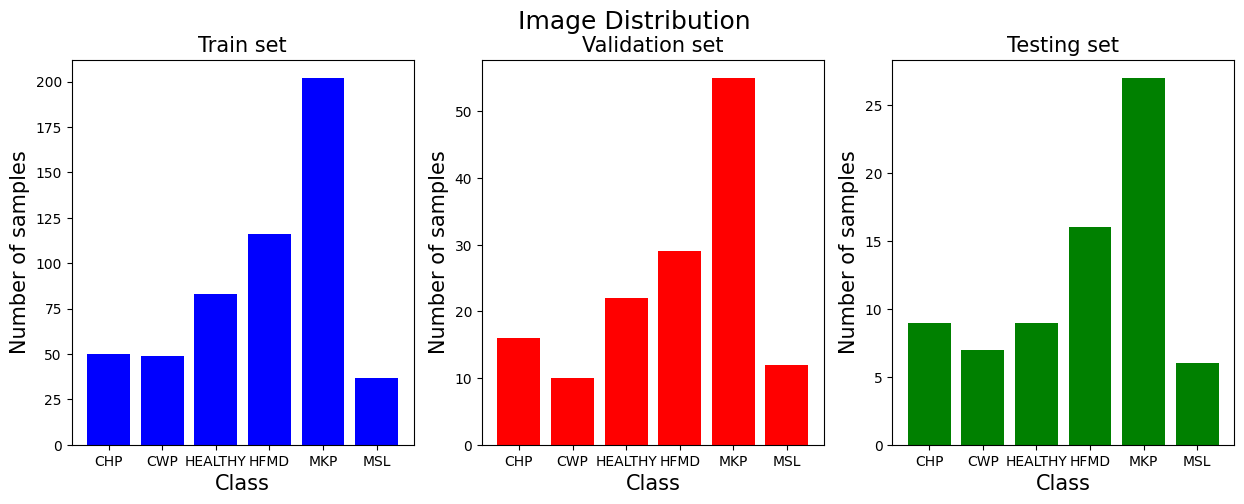

<Figure size 640x480 with 0 Axes>

In [37]:
def check_imbalance(dataset):
    '''
    Counts the number of samples in every class for a given dataset
    Arguments:
        dataset
    Returns:
        tuple (value for class 0, value for class 1)
    '''
    classes = [label for _,   label in dataset]
    index_0 = len([idx   for idx, label in enumerate(classes) if label == 0])
    index_1 = len([idx   for idx, label in enumerate(classes) if label == 1])
    index_2 = len([idx   for idx, label in enumerate(classes) if label == 2])
    index_3 = len([idx   for idx, label in enumerate(classes) if label == 3])
    index_4 = len([idx   for idx, label in enumerate(classes) if label == 4])
    index_5 = len([idx   for idx, label in enumerate(classes) if label == 5])
    return index_0, index_1, index_2, index_3, index_4, index_5

def plot_imbalance(train_dataset, valid_dataset, test_dataset):
    '''
    Creates the subplots and plots the class distribution
    '''
    class_count_train = check_imbalance(train_dataset)
    class_count_valid = check_imbalance(valid_dataset)
    class_count_tests = check_imbalance(test_dataset)

    fig, axs = plt.subplots(1, 3, figsize = (15, 5))
    fig.suptitle('Image Distribution', size = 18)
    labels = ['CHP', 'CWP', 'HEALTHY', 'HFMD', 'MKP', 'MSL']

    axs[0].bar(labels, class_count_train, color = 'blue')
    axs[0].set_title('Train set', size = 15)
    axs[0].set_xlabel('Class', size = 15)
    axs[0].set_ylabel('Number of samples', size = 15)

    axs[1].bar(labels, class_count_valid, color = 'red')
    axs[1].set_title('Validation set', size = 15)
    axs[1].set_xlabel('Class', size = 15)
    axs[1].set_ylabel('Number of samples', size = 15)

    axs[2].bar(labels, class_count_tests, color = 'green')
    axs[2].set_title('Testing set', size = 15)
    axs[2].set_xlabel('Class', size = 15)
    axs[2].set_ylabel('Number of samples', size = 15)
    plt.show()
    plt.tight_layout()

plot_imbalance(train_dataset, valid_dataset, test_dataset)

## A.5. Data Loader
The datasets and samplers are then fed into the <code>DataLoader</code>. Using the PyTorch dataset and managing it with the DataLoader keeps our data manageable and helps to simplify our deep learning pipeline. The <code>Dataset</code> stores our data and the <code>DataLoader</code> can be used to iterate through the data.

Our training and validation datasets consist of hundreds of images. Our device may not be able to handle such large volumes of data during CNN training. Therefore, we use a <code>batch_size</code> of 32 as a hyperparameter to specify the number of samples being fed into the CNN model before the model parameters are updated. In this way, our device is not overloaded with work and our model can learn very well. In addition, smaller batch sizes of 32 allow for more efficient memory usage.

In [9]:
def get_sampler(dataset):
    '''
    Description: Get weighted samples using Weighted Random Sampler
        Arguments:
            dataset: Any imbalanced dataset that requires oversampling
        Returns:
            dataset used with Weighted Random Sampler
    '''
    classes = [label for _,   label in dataset]
    index_0 = [idx   for idx, label in enumerate(classes) if label == 0]
    index_1 = [idx   for idx, label in enumerate(classes) if label == 1]
    index_2 = [idx   for idx, label in enumerate(classes) if label == 2]
    index_3 = [idx   for idx, label in enumerate(classes) if label == 3]
    index_4 = [idx   for idx, label in enumerate(classes) if label == 4]
    index_5 = [idx   for idx, label in enumerate(classes) if label == 5]

    weights = torch.zeros(len(index_0) + len(index_1) + len(index_2) + len(index_3) + len(index_4) + len(index_5))
    weights[index_0] = 1.0 / len(index_0)
    weights[index_1] = 1.0 / len(index_1)
    weights[index_2] = 1.0 / len(index_2)
    weights[index_3] = 1.0 / len(index_3)
    weights[index_4] = 1.0 / len(index_4)
    weights[index_5] = 1.0 / len(index_5)

    sampler = WeightedRandomSampler(weights = weights, num_samples = len(weights), replacement = True)
    return sampler

torch.manual_seed(42)
train_sampler = get_sampler(train_dataset)
valid_sampler = get_sampler(valid_dataset)

train_loader   = DataLoader(train_dataset, batch_size = 32, sampler = train_sampler)
valid_loader   = DataLoader(valid_dataset, batch_size = 32, sampler = valid_sampler)
test_loader    = DataLoader(test_dataset,  batch_size = 32, shuffle = False)

## A.6. Skin Tone Bias

The prevalence of skin-tone bias in MSLDv2.0 dataset is evident, as most of the images within classes such as Chickenpox, Cowpox, Measles, and HFMD primarily depict individuals with lighter skin tones. In contrast, the Monkeypox disease contains a mixture of individuals with both dark and light skin tones.

A recent report from the Centers for Disease Control and Prevention (CDC) highlights the distribution of mpox cases among different racial and
ethnic groups, thereby providing further evidence of this imbalance. Moreover, studies have shown that the over-reliance on color information in skin disease detection techniques has imposed limitations due to skin-tone bias in the dataset.

**It is vital to consider the skin tone distribution of the patient in every image in our dataset as this might lead to bias results from the CNN model.**


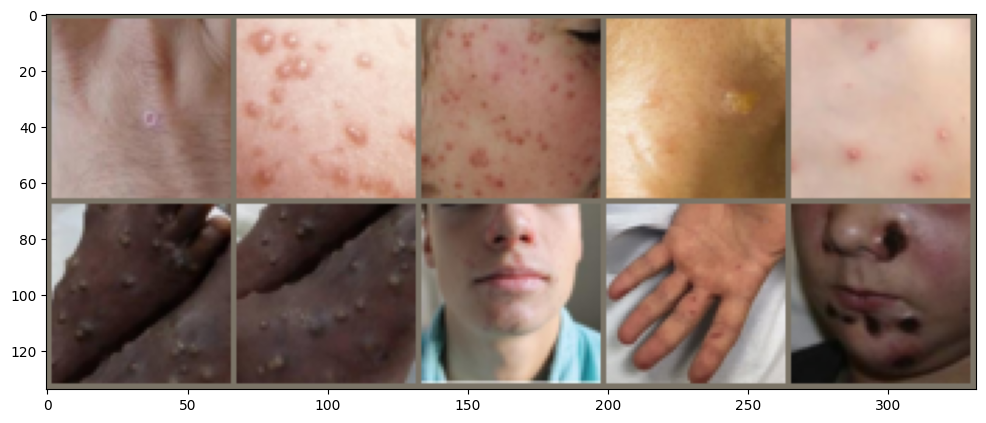

In [ ]:
for idx, (image, label) in enumerate(test_loader):
    if idx == 5:
        break
im = make_grid(image, nrow = 5)
inv_normalize = transforms.Normalize(
                    mean = [-0.485/0.229, -0.456/0.224, -0.406/0.225],
                    std  = [1/0.229, 1/0.224, 1/0.225])
im_inv = inv_normalize(im)
plt.figure(figsize = (12, 7))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)))

In [ ]:
for images, labels in train_loader:
    break
class_names = ['CHP', 'CWP', 'HEALTHY', 'HFMD', 'MKP', 'MSL']

print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

Label: [4 2 0 1 5 4 2 5 1 4 5 3 3 0 2 3 3 4 4 5 0 4 1 0 2 3 1 3 3 4 0 5]
Class:  MKP HEALTHY CHP CWP MSL MKP HEALTHY MSL CWP MKP MSL HFMD HFMD CHP HEALTHY HFMD HFMD MKP MKP MSL CHP MKP CWP CHP HEALTHY HFMD CWP HFMD HFMD MKP CHP MSL


# B. Model Deployment

## B.1. BaselineCNN
We built our CNN model using AlexNet as its foundational architecture, denoted as BaselineCNN. The model starts with two convolutional layers, followed with max-pooling and dropout layers to prevent overfitting. Batch normalization is also employed in the convolutional layers to stabilize and accelerate training.

The fully connected layers of the network include three linear (fully connected) layers with 6 units to represent the number of classes.

Our BaselineCNN has 13,054,470 parameters.

In [10]:
def count_parameters(model, print_all = True):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    if print_all:
        for item in params:
            print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

class BaselineCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,  64,  3, 1)
        self.conv2 = nn.Conv2d(64, 128, 3, 1)

        self.fc1 = nn.Linear(25088, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256,   6)

        self.dropout = nn.Dropout(p = 0.3)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.batchnorm2 = nn.BatchNorm2d(128)

    def forward(self, x):
        x = F.relu(self.batchnorm1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = F.relu(self.batchnorm2(self.conv2(x)))
        x = F.max_pool2d(x, 2)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

count_parameters(BaselineCNN(), False)

________
13054470


## B.2. Model Training and Functions

Prior to CNN model training, we created a function called <code>train</code> that simulates the whole training, validation, and testing process. This function requires the number of epochs <code>num_epochs</code>, CNN model <code>model</code>, the split datasets <code>train_loader, valid_loader</code>, and <code>test_loader</code>, optimization functions <code>optimizer, criterion, device</code>. The function <code>train</code> returns the losses, accuracy, metrics for training, validation, and testing.

The <code>train</code> function primarily utilizes the <code>_train</code> and <code>_evals</code> to simulate the training and validation process, respectively. The testing set can be simulated to the <code>_evals</code> as well. Both <code>_train</code> and <code>_evals</code> returns the losses and accuracies for one epoch and the <code>train</code> simulates the whole process altogether.

In [ ]:
pil_image = PIL.Image.open(df_main[df_main['label'] == 4][['filepath']].iloc[0,:][0])

normalizer = Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
torch_img = torch.from_numpy(np.asarray(pil_image)).permute(2, 0, 1).unsqueeze(0).float().div(255)
torch_img = F.upsample(torch_img, size = (224, 224), mode = 'bilinear', align_corners = False)
normed_torch_img = normalizer(torch_img)
resnet = models.resnet101(pretrained = True).eval()

cnn_models, layer_name, types = [resnet], ['layer4'], ['resnet']

def saliency_image(cnn_models, layer_name, types, input_size = (224, 224)):
    cam_dict = dict()
    for model, layer, type in zip(cnn_models, layer_name, types):
        model_dict = dict(type = type, arch = model, layer_name = layer, input_size = input_size)
        model_grad = GradCAM(model_dict, True)
        model_capp = GradCAMpp(model_dict, True)
        cam_dict[type] = [model_grad, model_capp]

        images = []
        for gradcam, gradcam_pp in cam_dict.values():
            mask, _ = gradcam(normed_torch_img)
            heatmap, result = visualize_cam(mask, torch_img)
            mask_pp, _ = gradcam_pp(normed_torch_img)
            heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)
            images.append(torch.stack([torch_img.squeeze().cpu(), heatmap, heatmap_pp, result, result_pp], 0))
        images = make_grid(torch.cat(images, 0), nrow = 5)
        return images

images = saliency_image(cnn_models, layer_name, types)
plt.figure(figsize = (40, 4))
plt.imshow(images.permute(1, 2, 0), interpolation = 'nearest')

In [11]:
def multiclass_accuracy(preds, y):
    '''
    Arguments:
        preds --> model output
        y     --> ground trutch
    Returns the accuracy of the model prediction
    '''
    _, preds = torch.max(preds, 1)
    rounded_preds = torch.round(preds)
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

def get_metrics(predictions, labels):
    _, predictions = torch.max(predictions, 1)
    predictions = predictions.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()

    f1 = np.round(f1_score(labels, predictions, average = 'weighted'), 3)
    return {'f1': f1}

def epoch_time(start_time, end_time):
    '''
    Arguments:
        start_time
        end_time
    Returns the elapsed minute and seconds of model training
    '''
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def test_model(model, test_loader):
    '''
        Arguments:
            model: CNN model to be tested
            test_loader
        Returns:
            confusion matrix and classification report of the CNN model
            using test_loader
    '''
    correct = 0
    total   = 0

    model.eval()
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total   += labels.size(0)
            correct += (predicted == labels).sum().item()

    predicted = predicted.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()

    accuracy = 100 * correct / total
    print('Test Accuracy: {:.2f}%'.format(accuracy))
    print('Confusion Matrix:')
    print(confusion_matrix(labels, predicted))
    print('Classification Report:')
    print(classification_report(labels, predicted, target_names = ['CHP', 'CWP', 'HEALTHY', 'HFMD', 'MKP', 'MSL']))
    return predicted, labels

def train(num_epochs, model, train_loader, valid_loader, test_loader, optimizer, criterion, device, accuracy = False):
    '''
    Arguments:
        num_epochs: Number of epochs for model training and validation (usually 100 epochs)
        model: CNN model in PyTorch
        train_loader: Training   set (map-style dataset) implemented from DataLoader constructor
        valid_loader: Validation set (map-style dataset) implemented from DataLoader constructor
        test_loader:  Testing    set (map-style dataset) implemented from DataLoader constructor
        optimizer:  Optimization model for adjusting the model parameters to reduce model error in each training set
                    You may specify optimizer-specific options such as learning rate, weight decay, etc.
                    Usual values are:
                        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
                        optimizer = optim.Adam([var1, var2], lr=0.0001)
        criterion: Loss function
        device: Location on which the tensor resides. If model training is on a local device without GPU, use 'cpu'.
                Otherwise, use 'cuda' especially using Google Colaboratory

        accuracy (boolean): If True, prints training and validation losses and accuracies
                            Otherwise, only training and validation losses
    Returns:
        train_losses, valid_losses: (lists) loss values of the model training and validation, respectively
        train_accurs, valid_accurs  (lists) accuracy values of training and validation, respectively
        test_loss, test_accu: (float) loss and accuracy values of testing
        train_metric, valid_metric: (dictionary) metrics from the get_metrics(prediction, label) function
        best_epoch: (int) epoch number with the best model (i.e., lowest loss and highest accuracy)
        epoch_times: (list) of epoch_mins and epoch_secs
        test_metric: (dictionary) metrics using testing set
        test_predictions: (list) Predictions of the model on a testing set
        best_model: (model) Best model version from the best_epoch
    '''
    best_valid_loss = float('inf')
    train_losses, valid_losses = [], []
    train_accurs, valid_accurs = [], []
    train_metric, valid_metric = [], []

    epoch_times = []
    list_best_epochs = []

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_accu, train_metr    = _train(model, train_loader, optimizer, criterion, device)
        valid_loss, valid_accu, valid_metr, _ = _evals(model, valid_loader, criterion, device)

        if epoch % 10 == 0:
          print(f'Epoch: {epoch + 1} \t Training: Loss {np.round(train_loss, 5)}   \t Accuracy: {np.round(train_accu, 5)} \t Validation Loss  {np.round(valid_loss, 5)} \t Accuracy: {np.round(valid_accu, 5)}')

        train_losses.append(train_loss)
        train_accurs.append(train_accu)
        train_metric.append(train_metr)
        valid_losses.append(valid_loss)
        valid_accurs.append(valid_accu)
        valid_metric.append(valid_metr)

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model = copy.deepcopy(model)
            best_epoch = epoch
        list_best_epochs.append(best_epoch)
    test_loss, test_accu, test_metric, test_predictions  = _evals(best_model, train_loader, criterion, device)
    print(f'Final Best Model from Best Epoch {best_epoch + 1} Test Loss = {test_loss}, Test Accuracy = {test_accu}')
    return train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, train_metric, valid_metric, best_epoch, epoch_times, test_metric, test_predictions, best_model

def _train(model, train_loader, optimizer, criterion, device):
    '''
    Description: _train is used for every one epoch
    Arguments:
        model: CNN model and should be instantiated to the device location (i.e., 'cpu' or 'cuda')
        train_loader: Training dataset loaded in PyTorch's DataLoader
        optimizer: Optimizing function to reduce the loss (usually Adam)
        criterion: Loss function to evaluate the prediction and target at one epoch
        device: Location on which the tensor resides. If model training is on a local device without GPU, use 'cpu'.
                Otherwise, use 'cuda' especially using Google Colaboratory
    Returns:
        epoch_train_loss (float): Training loss at one epoch
        epoch_train_accu (float): Training accuracy at one epoch
        metric (dictionary): Training metrics based on the function get_metrics()
    '''
    model.train()
    epoch_train_loss = 0
    epoch_train_accu = 0

    for idx, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

        accuracy = multiclass_accuracy(outputs, labels)
        metric   = get_metrics(outputs, labels)

        epoch_train_accu += accuracy.item()

    epoch_train_loss = epoch_train_loss / len(train_loader)
    epoch_train_accu = epoch_train_accu / len(train_loader)
    return epoch_train_loss, epoch_train_accu, metric

def _evals(model, valid_loader, criterion, device):
    '''
    Description: _evals is used for every one epoch for validation and testing
    Arguments:
        model: CNN model and should be instantiated to the device location (i.e., 'cpu' or 'cuda')
        valid_loader: Validation dataset loaded in PyTorch's DataLoader
        optimizer: Optimizing function to reduce the loss (usually Adam), should be the same in _train
        criterion: Loss function to evaluate the prediction and target at one epoch, should be the same in _train
        device: Location on which the tensor resides. If model training is on a local device without GPU, use 'cpu'.
                Otherwise, use 'cuda' especially using Google Colaboratory
    Returns:
        epoch_valid_loss (float): Validation loss at one epoch
        epoch_valid_accu (float): Validation accuracy at one epoch
        metric (dictionary): Training metrics based on the function get_metrics()
    '''
    model.eval()
    epoch_valid_loss = 0
    epoch_valid_accu = 0

    all_predictions = []

    with torch.no_grad():
        for id, data in enumerate(valid_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            all_predictions.extend(outputs)

            epoch_valid_loss += loss.item()
            accuracy = multiclass_accuracy(outputs, labels)
            metric   = get_metrics(outputs, labels)
            epoch_valid_accu += accuracy.item()
    epoch_valid_loss = epoch_valid_loss / len(valid_loader)
    epoch_valid_accu = epoch_valid_accu / len(valid_loader)
    return epoch_valid_loss, epoch_valid_accu, metric, all_predictions

def plot_metrics(train_losses, valid_losses, train_accurs, valid_accurs):
    alpha_train, alpha_valid = 0.2, 0.5
    smoothed_train_losses = [train_losses[0]]
    smoothed_valid_losses = [valid_losses[0]]
    smoothed_train_accurs = [train_accurs[0]]
    smoothed_valid_accurs = [valid_accurs[0]]

    for i in range(1, len(train_losses)):
        smoothed_train_losses.append(alpha_train * train_losses[i] + (1-alpha_train) * smoothed_train_losses[-1])
        smoothed_valid_losses.append(alpha_valid * valid_losses[i] + (1-alpha_valid) * smoothed_valid_losses[-1])
        smoothed_train_accurs.append(alpha_train * train_accurs[i] + (1-alpha_train) * smoothed_train_accurs[-1])
        smoothed_valid_accurs.append(alpha_valid * valid_accurs[i] + (1-alpha_valid) * smoothed_valid_accurs[-1])

    smoothed_train_losses = train_losses
    smoothed_train_accurs = train_accurs
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
    ax1.plot(smoothed_train_losses, label = 'Train')
    ax1.plot(smoothed_valid_losses, label = 'Valid')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Losses')
    ax1.legend()

    ax2.plot(smoothed_train_accurs, label='Train')
    ax2.plot(smoothed_valid_accurs, label='Valid')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracies')
    ax2.legend()
    plt.show()


def simulation_plots(train_losses, valid_losses, train_accurs, valid_accurs):
    alpha_train, alpha_valid = 0.2, 0.5
    smoothed_train_losses = [train_losses[0]]
    smoothed_valid_losses = [valid_losses[0]]
    smoothed_train_accurs = [train_accurs[0]]
    smoothed_valid_accurs = [valid_accurs[0]]

    for i in range(1, len(train_losses)):
        smoothed_train_losses.append(alpha_train * train_losses[i] + (1-alpha_train) * smoothed_train_losses[-1])
        smoothed_valid_losses.append(alpha_valid * valid_losses[i] + (1-alpha_valid) * smoothed_valid_losses[-1])
        smoothed_train_accurs.append(alpha_train * train_accurs[i] + (1-alpha_train) * smoothed_train_accurs[-1])
        smoothed_valid_accurs.append(alpha_valid * valid_accurs[i] + (1-alpha_valid) * smoothed_valid_accurs[-1])

    smoothed_train_losses = train_losses
    smoothed_train_accurs = train_accurs
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
    ax1.plot(smoothed_train_losses, label = 'Train')
    ax1.plot(smoothed_valid_losses, label = 'Valid')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Losses')
    ax1.legend()

    ax2.plot(smoothed_train_accurs, label='Train')
    ax2.plot(smoothed_valid_accurs, label='Valid')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracies')
    ax2.legend()
    plt.show()

def saliency_image(cnn_models, layer_name, types, input_size = (224, 224)):
    pil_image = PIL.Image.open(df_main[df_main['label'] == 5][['filepath']].iloc[5, :][0])
    normalizer = Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    torch_img = torch.from_numpy(np.asarray(pil_image)).permute(2, 0, 1).unsqueeze(0).float().div(255)
    torch_img = F.upsample(torch_img, size = (224, 224), mode = 'bilinear', align_corners = False)
    normed_torch_img = normalizer(torch_img)
    
    cam_dict = dict()
    for model, layer, type in zip(cnn_models, layer_name, types):
        model_dict = dict(type = type, arch = model, layer_name = layer, input_size = input_size)
        model_grad = GradCAM(model_dict, True)
        model_capp = GradCAMpp(model_dict, True)
        cam_dict[type] = [model_grad, model_capp]

        images = []
        for gradcam, gradcam_pp in cam_dict.values():
            mask, _ = gradcam(normed_torch_img)
            heatmap, result = visualize_cam(mask, torch_img)
            mask_pp, _ = gradcam_pp(normed_torch_img)
            heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)
            images.append(torch.stack([torch_img.squeeze().cpu(), heatmap, heatmap_pp, result, result_pp], 0))
        images = make_grid(torch.cat(images, 0), nrow = 5)
        return images

resnet = models.resnet152(pretrained = True).eval()
cnn_models, layer_name, types = [resnet], ['layer4'], ['resnet']
images = saliency_image(cnn_models, layer_name, types)
plt.figure(figsize = (40, 4))
plt.imshow(images.permute(1, 2, 0), interpolation = 'nearest')

## B.3. BaselineCNN Results
**Question 3-4. Conduct CNN with 6 classes for the baseline model. Other hyperparameters are not controlled. Saliency map should be applied. Report the results for the baseline model with appropriate metrics and criticize the results from the baseline model based on theoretical and practical perspective.** 

We conducted a pre-simulation process in order to check the validity of our parameters and hyperparameters for the BaselineCNN. These parameters include the effect of learning rates and optimizers to our model. Results have shown that BaselineCNN will stabilize at 100 epochs using 0.001 learning rate. We also tried simulating SGD, RMSProp, and ADAM as the model optimizers. However, SGD does not converge to its local optima when it reached 100 iterations due to vanishing gradients. Meanwhile, RMSProp and ADAM have almost similar results but we chose ADAM due to its efficacy, speed, and momentum in calculating model gradients.

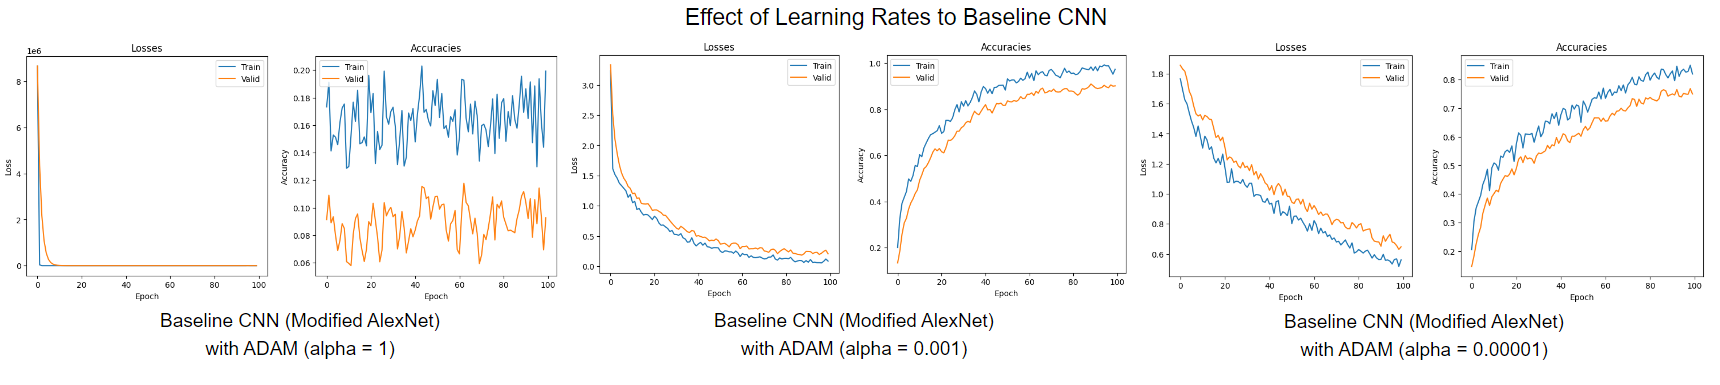

The plot and accuracies for the following code is indicated above (middle). The plot above shows the losses and accuracy of the training and validation sets using different optimizers. The plot above suggests that the model is likely to generalize well to new data and is unlikely to be overfitting nor underfitting. This indicates the <code>BaselineCNN</code> may have learned the underlying patterns of the data. Both the training and validation sets achieved an accuuracy greater than 85%, which can be a very good sign that our (first) model can classify images based on lesion classification. However, it is important to note that loss values and accuracy may not fully represent the model's performance, as it can vary based on the evaluation metrics and problem. Therefore, careful analysis and interpretation of the loss values, in the context of the specific problem and experimental setup, is crucial. Both training and validation sets are converging to the local minima, but produces fluctuations at certain iterations. This suggests that the model is learning the underlying patterns of the images but can also experience some degree of variability in the training process. This may be due to the model complexity, size and variability of the dataset, or even the training and validation split. 

In [ ]:
model_baseline = BaselineCNN()
if torch.cuda.is_available():
    model_baseline.cuda()

## Loss and accuracy plot above (middle section)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_baseline.parameters(), lr = 0.001)
train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, train_metric, valid_metric, best_epoch, epoch_times, test_metric, test_predictions, best_model = train(100, model_baseline, train_loader, valid_loader, test_loader, optimizer, criterion, device)
predictions, labels = test_model(best_model, train_loader)

Epoch: 1 	 Training: Loss 3.23434   	 Accuracy: 0.20029 	 Validation Loss  3.32378 	 Accuracy: 0.12594
Epoch: 11 	 Training: Loss 1.05196   	 Accuracy: 0.60301 	 Validation Loss  1.12417 	 Accuracy: 0.54604
Epoch: 21 	 Training: Loss 0.82812   	 Accuracy: 0.69574 	 Validation Loss  0.91619 	 Accuracy: 0.63378
Epoch: 31 	 Training: Loss 0.5254   	 Accuracy: 0.8136 	 Validation Loss  0.61601 	 Accuracy: 0.72061
Epoch: 41 	 Training: Loss 0.37038   	 Accuracy: 0.88971 	 Validation Loss  0.46659 	 Accuracy: 0.79465
Epoch: 51 	 Training: Loss 0.24863   	 Accuracy: 0.93199 	 Validation Loss  0.33544 	 Accuracy: 0.8561
Epoch: 61 	 Training: Loss 0.20914   	 Accuracy: 0.93515 	 Validation Loss  0.3037 	 Accuracy: 0.85698
Epoch: 71 	 Training: Loss 0.12073   	 Accuracy: 0.97243 	 Validation Loss  0.19489 	 Accuracy: 0.89755
Epoch: 81 	 Training: Loss 0.13231   	 Accuracy: 0.95721 	 Validation Loss  0.21841 	 Accuracy: 0.90059
Epoch: 91 	 Training: Loss 0.06632   	 Accuracy: 0.98478 	 Validation

We assessed the BaselineCNN's performance using key metrics. The overall model produced a 74.67% accuracy on testing sets. In terms of the predictive performance of every class, chickenpox predictions achieved 67% precision, while Cow Pox reached 86%, Healthy cases 40%, HFMD 80%, and Monkeypox and Measles obtained perfect precision scores. On the recall side, BaselineCNN captured only 50% of chickenpox cases, 86% for Cow Pox, and 67% for healthy cases. Surprisingly, HFMD was captured entirely, but Monkeypox and Measles had lower recalls, indicating some missed instances.

Regarding F1-scores, HFMD, MKP, and MSL demonstrated the highest scores (0.89), showcasing a balanced blend of precision and recall. CWP also had a strong F1-score of 0.86, indicating a well-balanced performance. However, CHP and HEALTHY displayed lower F1-scores (0.57 and 0.50), revealing an imbalance.

The macro-average F1-score stood at 0.73, while the weighted-average F1-score was slightly higher at 0.76, reflecting class distribution's impact on BaselineCNN's performance. In conclusion, BaselineCNN delivered relatively good results with high precision and F1-scores for HFMD, MKP, and MSL. Yet, improvements are needed in capturing all instances (recall) for classes like CHP and MSL.

## B.4. Baseline CNN Discussion
BaselineCNN is a good starting point! However, while validation losses for BaselineCNN is unlikely to overfit or underfit, its results, cannot fully classify the images to its corresponding lesion labels. Primarily, BaselineCNN is a relatively simple CNN architecture. Our dataset comprises intricate patterns, including small lesions and variations in skin tones, which demand more complex and deeper models for improved classification performance. The challenge arises in integrating these necessary model features into BaselineCNN, as it necessitates dimensionality reduction and specific feature maps. For instance, finer detail discernment in lesion images requires the utilization of smaller feature maps (i.e., 1 x 1 convolutions). In contrast, BaselineCNN, which employs standard convolutions (i.e., 3 x 3 or 5 x 5), lacks this capability, hindering the smooth flow of gradients during training.

We applied Gradient-weighted Class Activation Mapping (GradCAM) to gain a deeper understanding of BaselineCNN's performance. This technique illustrates the decision-making process of BaselineCNN in classifying images into their respective categories. Notably, regions highlighted in red signify pixel features relevant to BaselineCNN's classification decisions. GradCAM aids in pinpointing which areas of an image carry the most weight for a specific classification. Initial results shed light on the model's limitations; CHP and HEALTHY exhibit lower F1-scores, primarily because BaselineCNN struggles to capture the intricate details specific to these classes. Instead, the model focuses on non-unique aspects, resulting in misclassifications. BaselineCNN may consider these intricate details as noise and may struggle with CHP and HEALTHY class with adversarial attacks, compression articfacts, and other forms of distortion. Existing studies have concluded that while AlexNet (as BaselineCNN's foundational architecture) can detect noisem it may not be robust to certain types of noise - especially in dealing with real-world variations. In contrast, HFMD, MKP, and MSL fare well in classification, as BaselineCNN effectively identifies the pertinent features. As a result, there is a compelling need to explore and propose a more robust model for the accurate classification of these skin lesions.

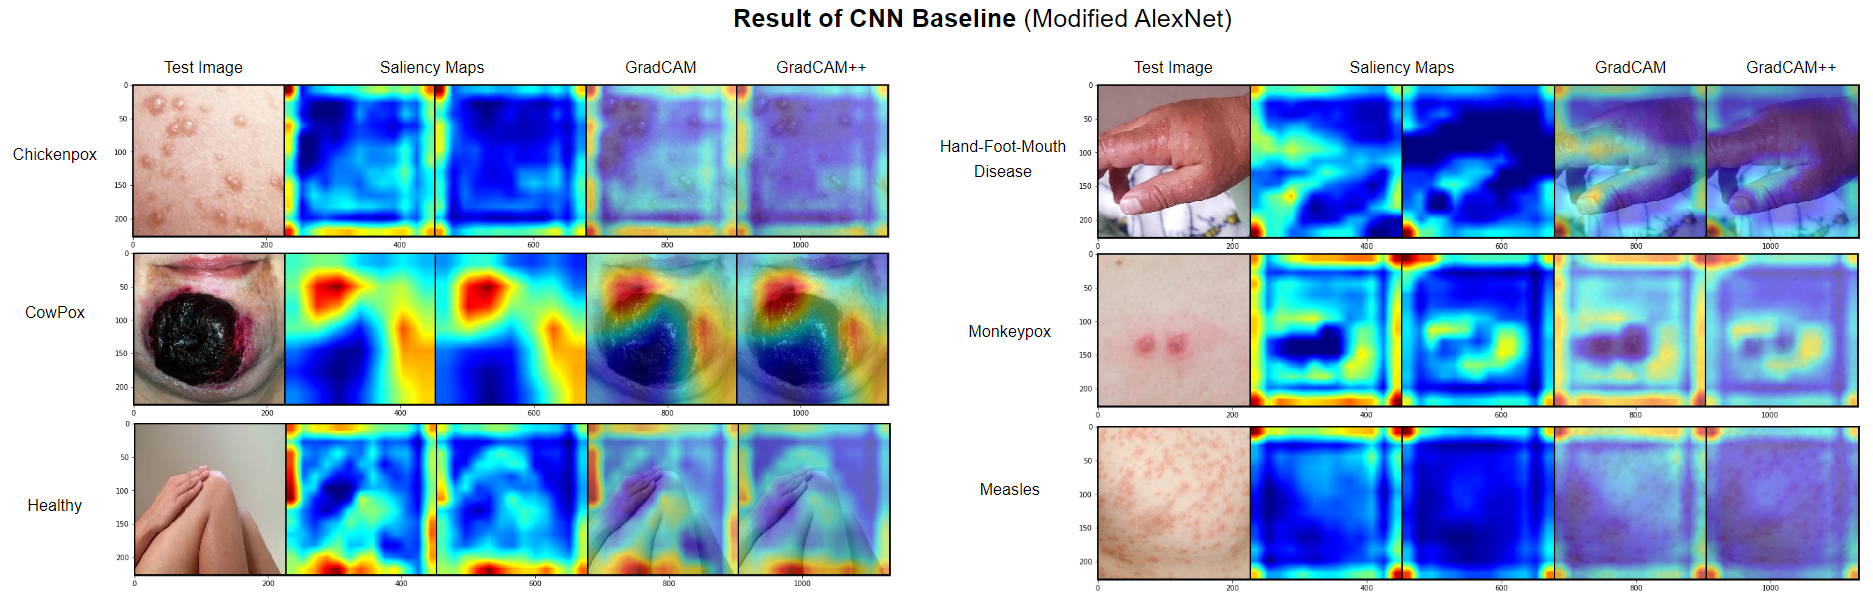

Note: We utilized two GradCAM methods for model interpretability as recommended by Jamil et al. (2023) since it captured the information from multiple layers of the network. We hypothesized that GradCAM++ may be able to detect the model's interpretation with the existence of bias (e.g. skin tones, noise).

# C. Proposed Model 1: Residual Networks + BottleNeck
**Questions 5-8: Propose the better model and provide assumptionns why your proposed model is better than the baseline model. Conduct an experiment on your proposed model. Report the results obtained from your proposed model with appropriate metrics and criticize the results from the proposed model based on theoretical and practical perspective. Please provide supporting evidence in all decisions performed on your experiment.**

- TLDR: **ResNet + BottleNeck Layers = improve classification performance + capture small details of the lesions**

Residual Networks (ResNet) represent a significant advancement in deep neural network architectures, primarily designed to address the challenges in AlexNet. ResNets introduced residual connections (or skip connections) that enable the network to skip one or more layers during forward and backward propagation. By allowing the network to learn residual functions (the difference between the output and the input of a layer), ResNets mitigate the vanishing gradient problem that often hampers training in extremely deep networks. 

Previous studies have utilized ResNet for skin lesion detection. Ali et al. (2023) utilized VGG16, ResNet50, DenseNet121, MobileNetV2, EfficientNetB3, InceptionV3, and Xception to reduce the impact of racial bias by adopting a color space augmentation with varying HSV parameters on a skin lesion image. DenseNet121 and ResNet50 produced the highest accuracy with 81.70 and 77.94%, respectively. However, we assume that ResNet may be able to produce higher performance if we will use bottleneck layers. These layers serve as a feature extraction module for ResNet models to distinguish small and intricate details, such as small poxes. These layers can also provide channel augmentation with computational efficiency and training stability. These layers are typically composed of 1x1 convolutions, which drastically reduce the number of parameters and computations compared to standard 3x3 or 5x5 convolutions. By introducing dimensionality reduction, bottleneck layers ensure smoother gradient flow and more efficient training that improves representation learning by helping the network capture compact and informative features. These features may potentially address BaselineCNN's limitation in distinguishing finer details of lesion in the images. 
 
The incorporation of bottleneck layers results in networks that are computationally efficient and capable of handling deep architectures without excessive computational demands. In contrast, AlexNet, the base architecture of BaselineCNN, uses standard convolutions without residual connections and bottleneck layers. While effective for its time, this architecture does not offer the same advantages for training very deep networks as ResNets. The key differences between ResNets with bottleneck layers and AlexNet lie in their approach in capturing fine, intricate details in the images.

In [ ]:
class BottleneckBlock(nn.Module):
    EXPANSION = 4
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size = 1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size = 3, stride=stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.EXPANSION * planes, kernel_size=1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.EXPANSION * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.EXPANSION * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.EXPANSION * planes,
                          kernel_size=1, stride = stride, bias = False),
                nn.BatchNorm2d(self.EXPANSION * planes)
            )
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512 * block.EXPANSION, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.EXPANSION
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet50(num_classes  = 6):
    return ResNet(BottleneckBlock, [3, 4, 6, 3], num_classes)
def ResNet101(num_classes = 6):
    return ResNet(BottleneckBlock, [3, 4, 23, 3], num_classes)
def ResNet152(num_classes = 6):
    return ResNet(BottleneckBlock, [3, 8, 36, 3], num_classes)

In this section, we utilized three versions of ResNet with BottleNeck layers. ResNet50, ResNet101, and ResNet152 are variations of the ResNet architecture, with differing depths and capacities. ResNet50 has 50 weight layers, ResNet101 has 101, and ResNet152 has 152. The primary difference lies in their network depth, which allows for more complex feature extraction and representation learning. The deeper models (ResNet101 and ResNet152) have more parameters, making them capable of capturing finer details and complex patterns in images, which can improve classification performance. **These models can discern subtle variations in skin lesions, such as shape, texture, and color, enabling more accurate classification.**

## C.1 ResNet50 + BottleNeck

In [ ]:
model_resnet50 = ResNet50().to(device)
count_parameters(model_resnet50, print_all = False)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet50.parameters(), lr = 0.001)
train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, train_metric, valid_metric, best_epoch, epoch_times, test_metric, test_predictions, best_model = train(100, model_resnet50, train_loader, valid_loader, test_loader, optimizer, criterion, device)
predictions, labels = test_model(model_resnet50, train_loader)

________
23512646
Epoch: 1 	 Training: Loss 2.35804   	 Accuracy: 0.19743 	 Validation Loss  2.4397 	 Accuracy: 0.10005
Epoch: 11 	 Training: Loss 1.43602   	 Accuracy: 0.44949 	 Validation Loss  1.49292 	 Accuracy: 0.38315
Epoch: 21 	 Training: Loss 1.22569   	 Accuracy: 0.52088 	 Validation Loss  1.31782 	 Accuracy: 0.44588
Epoch: 31 	 Training: Loss 1.0826   	 Accuracy: 0.57493 	 Validation Loss  1.14659 	 Accuracy: 0.48652
Epoch: 41 	 Training: Loss 0.93999   	 Accuracy: 0.65346 	 Validation Loss  1.01895 	 Accuracy: 0.57232
Epoch: 51 	 Training: Loss 0.73238   	 Accuracy: 0.73772 	 Validation Loss  0.79536 	 Accuracy: 0.6491
Epoch: 61 	 Training: Loss 0.54099   	 Accuracy: 0.81125 	 Validation Loss  0.62812 	 Accuracy: 0.71778
Epoch: 71 	 Training: Loss 0.62331   	 Accuracy: 0.78338 	 Validation Loss  0.69313 	 Accuracy: 0.69899
Epoch: 81 	 Training: Loss 0.49335   	 Accuracy: 0.81676 	 Validation Loss  0.59106 	 Accuracy: 0.73338
Epoch: 91 	 Training: Loss 0.43128   	 Accuracy: 0

Similar to BaselineCNN, high precision (1.00) is observed for chickenpox (CHP) and monkeypox (MKP), indicating accurate predictions for these classes. Cowpox (CWP) exhibits a precision of 0.60, leaving room for improvement. Conversely, predictions for healthy individuals (HEALTHY) show lower precision at 0.40. Hand, foot, and mouth disease (HFMD) displays relatively good precision (0.75), while measles (MSL) achieves high precision at 1.00.

F1-scores reveal that CHP, MKP, and MSL achieve a balanced performance. CWP attains an F1-score of 0.75, indicating reasonable balance. However, HEALTHY and MKP exhibit F1-scores of 0.57 and 0.55, respectively, indicating an imbalance. HFMD achieves a balanced F1-score of 0.75.

Overall accuracy remains constant at 76%, representing the proportion of correctly classified samples out of 25. The macro-average F1-score slightly improves to 0.77 in ResNet50 from 0.73 in BaselineCNN, indicating better balance between precision and recall. However, the weighted-average F1-score drops to 0.75 from 0.76 in BaselineCNN. In comparison to BaselineCNN, ResNet50 shows enhancements in precision, recall, and F1-scores for CHP, CWP, HEALTHY, and HFMD. Opportunities for improvement persist, especially in capturing all MKP instances and achieving better precision-recall balance for HEALTHY. 

ResNet50's improvements, when compared to the BaselineCNN, can be attributed to several factors. Notably, ResNet50 with bottleneck layers is renowned for its deep structure and the use of residual connections, which can mitigate the vanishing gradient problem. This enables ResNet50 to capture intricate features and patterns within the data more effectively. In addition, the bottleneck layers refines feature extraction and representation. Consequently, ResNet50 can discern the finer details in the skin lesion images, leading to improved classification performance across multiple classes.

## C.2 ResNet101 + BottleNeck

In [ ]:
# 22 mins
model_resnet101 = ResNet101().to(device)
count_parameters(model_resnet101, print_all = False)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet101.parameters(), lr = 0.001)
train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, train_metric, valid_metric, best_epoch, epoch_times, test_metric, test_predictions, best_model = train(100, model_resnet101, train_loader, valid_loader, test_loader, optimizer, criterion, device)
predictions, labels = test_model(model_resnet101, train_loader)

________
42504774
Epoch: 1 	 Training: Loss 2.13219   	 Accuracy: 0.21368 	 Validation Loss  2.20384 	 Accuracy: 0.12392
Epoch: 11 	 Training: Loss 1.50503   	 Accuracy: 0.38699 	 Validation Loss  1.57159 	 Accuracy: 0.28782
Epoch: 21 	 Training: Loss 1.31641   	 Accuracy: 0.47941 	 Validation Loss  1.37902 	 Accuracy: 0.38844
Epoch: 31 	 Training: Loss 1.30105   	 Accuracy: 0.53162 	 Validation Loss  1.38683 	 Accuracy: 0.43714
Epoch: 41 	 Training: Loss 0.98703   	 Accuracy: 0.62618 	 Validation Loss  1.06453 	 Accuracy: 0.53819
Epoch: 51 	 Training: Loss 0.89051   	 Accuracy: 0.66316 	 Validation Loss  0.96895 	 Accuracy: 0.58246
Epoch: 61 	 Training: Loss 0.89742   	 Accuracy: 0.67684 	 Validation Loss  0.96793 	 Accuracy: 0.59386
Epoch: 71 	 Training: Loss 0.73322   	 Accuracy: 0.72015 	 Validation Loss  0.79761 	 Accuracy: 0.64186
Epoch: 81 	 Training: Loss 0.7922   	 Accuracy: 0.7036 	 Validation Loss  0.84364 	 Accuracy: 0.65322
Epoch: 91 	 Training: Loss 0.55168   	 Accuracy: 

Results have shown that ResNet101 produced test accuracy of 83.99%, which is slightly lower than the accuracy achieved by ResNet50 (90.13%). In ResNet101, the precision for various classes varies. For CHP (chickenpox), CWP (cox pox), and HEALTHY, the precision is perfect (1.00), indicating that when the model predicts these classes, it is almost always correct. However, the precision for MKP (monkeypox) and MSL (measles) is lower, indicating that there may be some room for improvement in the model's predictions for these classes. The recall for most classes is also strong, particularly for HFMD (hand, foot, and mouth disease), where it is 1.00. Overall, the results suggest a good balance between precision and recall for several classes.

The F1-scores in ResNet101 are generally good, and the model shows a reasonably balanced performance across various classes. Some classes, like CHP and HFMD, have high F1-scores, indicating a good balance between precision and recall. However, classes like MKP have a lower F1-score, indicating that precision and recall are not well balanced for this class.

The reason for ResNet101's performance might be attributed to its increased model depth and capacity compared to ResNet50. Deeper models, like ResNet101, can capture more complex and intricate features in the data, potentially leading to better classification. However, the trade-off is that deeper models can be more susceptible to overfitting, which may explain the slight drop in accuracy compared to ResNet50.

## C.3 ResNet152 + BottleNeck

In [ ]:
model_resnet152 = ResNet152().to(device)
count_parameters(model_resnet152, print_all = False)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet152.parameters(), lr = 0.001)
train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, train_metric, valid_metric, best_epoch, epoch_times, test_metric, test_predictions, best_model = train(100, model_resnet152, train_loader, valid_loader, test_loader, optimizer, criterion, device)
predictions, labels = test_model(model_resnet152, train_loader)

________
58148422
Epoch: 1 	 Training: Loss 2.41887   	 Accuracy: 0.20868 	 Validation Loss  2.7006 	 Accuracy: 0.12208
Epoch: 11 	 Training: Loss 1.48018   	 Accuracy: 0.37596 	 Validation Loss  1.77186 	 Accuracy: 0.22805
Epoch: 21 	 Training: Loss 1.22862   	 Accuracy: 0.5361 	 Validation Loss  1.29772 	 Accuracy: 0.45182
Epoch: 31 	 Training: Loss 1.15877   	 Accuracy: 0.55816 	 Validation Loss  1.34257 	 Accuracy: 0.48995
Epoch: 41 	 Training: Loss 1.10505   	 Accuracy: 0.57 	 Validation Loss  1.39999 	 Accuracy: 0.37978
Epoch: 51 	 Training: Loss 0.97241   	 Accuracy: 0.67419 	 Validation Loss  1.16068 	 Accuracy: 0.48865
Epoch: 61 	 Training: Loss 0.8434   	 Accuracy: 0.68441 	 Validation Loss  0.97379 	 Accuracy: 0.58546
Epoch: 71 	 Training: Loss 0.8222   	 Accuracy: 0.70676 	 Validation Loss  0.88688 	 Accuracy: 0.60733
Epoch: 81 	 Training: Loss 0.7376   	 Accuracy: 0.73985 	 Validation Loss  0.90944 	 Accuracy: 0.59587
Epoch: 91 	 Training: Loss 0.57059   	 Accuracy: 0.7915

ResNet152 achieves high precision and recall for most classes. It demonstrates excellent precision and recall for CHP (chickenpox), CWP (cox pox), HFMD (hand, foot, and mouth disease), and MSL (measles). In comparison to BaselineCNN, which had an accuracy of 76%, ResNet152 with bottleneck layers demonstrates significantly superior performance, achieving an accuracy of 88.64%. The use of a more advanced architecture like ResNet152, along with bottleneck layers, enables better feature extraction and classification. Moreover, the F1-scores for ResNet152 are generally high, indicating a balanced trade-off between precision and recall for most classes. 
 
 The plot and accuracies for the following code is indicated below. The plot suggests that ResNet, across its variants, is likely to generalize well to new data and is unlikely to be overfitting nor underfitting. This indicates the <code>ResNet</code> may have learned the underlying patterns of the data. Both the training and validation sets achieved an accuuracy greater than 70%, which can be a very good sign that our ResNet improved the performance from the BaselineCNN. Both training and validation sets are converging to the local minima, but produces fluctuations at certain iterations. This suggests that the model is learning the underlying patterns of the images but can also experience some degree of variability in the training process. This may be due to the model complexity, size and variability of the dataset, or even the training and validation split. 


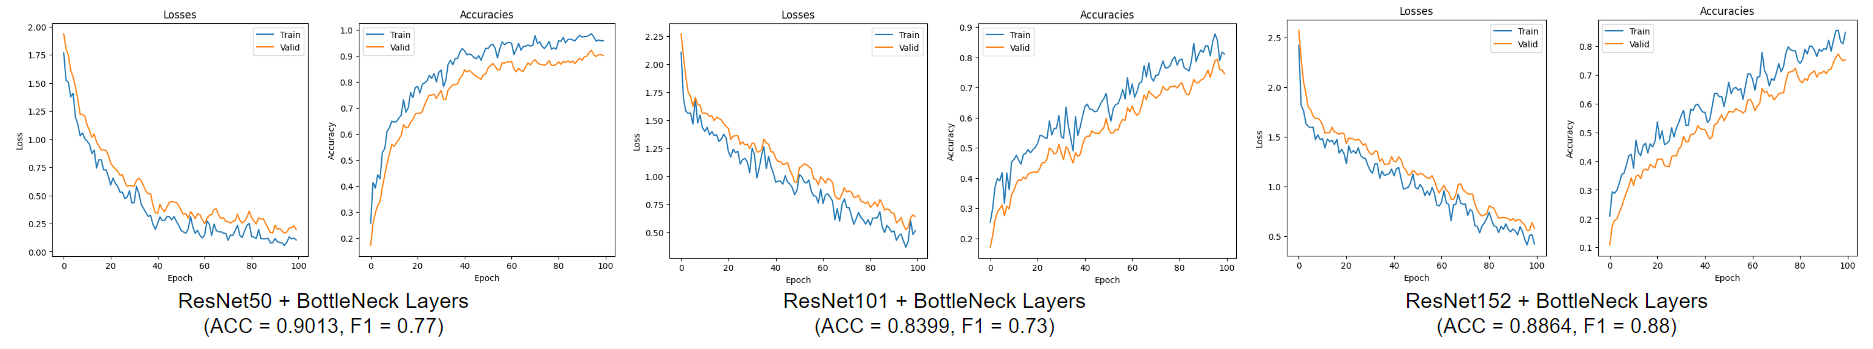

In comparison to BaselineCNN, ResNet produced improved performance since it can detect the intricate details of the lesions of every lesions. For instance, ResNet can detect the spots in chickenpox cases. Even more so, the ResNet can distinguish patterns of lesions even though there are color disparities, especially in Cox Pox cases. However, while ResNet produced improved results than the BaselineCNN, GradCAM shows there are overlaps of feature pixels that the ResNet predicts. These certain features may not correspond to a class, which may provide misclassifications. This phenomenon occurs since ResNet did not calibrate its results. ResNet, including its bottleneck layers, cannot capture the importance of each channel in feature maps and emphasize more relevant channels while suppressing less relevant ones.  

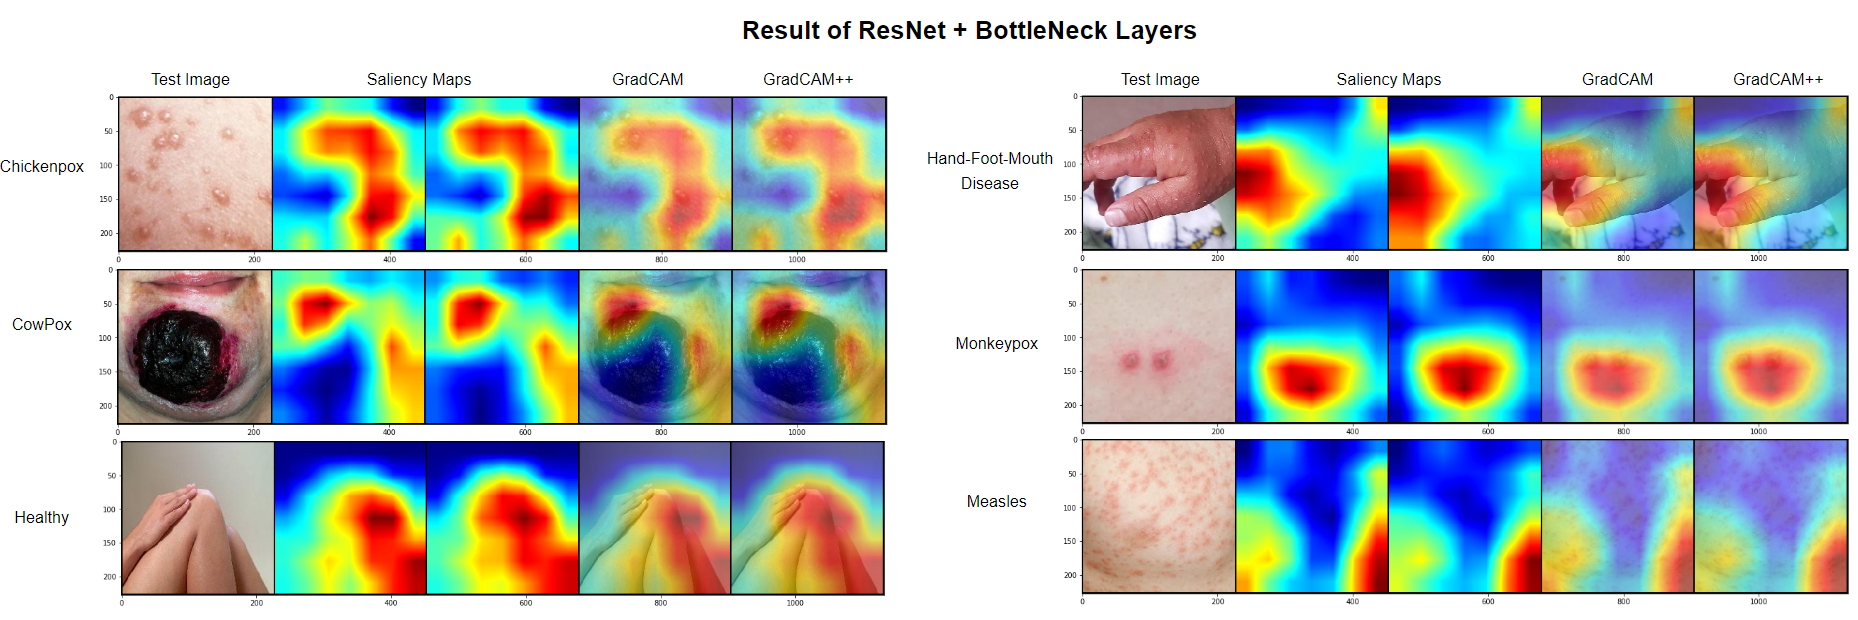

# D. Proposed Model 2: ResNet + BottleNeck + Squeeze and Excitation 

**TLDR: SE Blocks = Recalibration**

Traditional CNNs (e.g., our baseline CNN) identify objects in images by progressively extracting features from low-level details like edges and curves to more abstract concepts. Squeeze-and-Excitation blocks (SE blocks) enhance this process by adaptively weighting each feature channel based on its relevance to the task at hand. In this work, we incorporate SE blocks into the bottleneck layers of a ResNet architecture to selectively emphasize important features and suppress less informative ones.  

SE blocks dynamically recalibrate the importance of different feature channels based on their relevance to the classification task. This is crucial when dealing with subtle visual cues, like small poxes, as it allows the model to focus on the most informative features and suppress irrelevant ones. In addition, small features, such as poxes, can be easily obscured by noise or background clutter in images. SE blocks help mitigate this issue by selectively emphasizing the relevant features and suppressing noise, leading to a cleaner and more informative representation.

In this section, we incorporated SE Blocks to the ResNet models to improve the performance above. 

In [ ]:
class SELayer(nn.Module):
    def __init__(self, channel, reduction = 16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias = False),
            nn.ReLU(inplace = True),
            nn.Linear(channel // reduction, channel, bias = False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class ResidualSEBasicBlock(nn.Module):
    EXPANSION = 1

    def __init__(self, in_planes, out_planes, stride = 1, reduction = 16):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size = 3,
                               stride=1, padding=1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.se = SELayer(out_planes, reduction)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.EXPANSION * out_planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.se(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

def ResSENet50(num_classes = 6):
    return ResNet(ResidualSEBasicBlock, [3, 4, 6, 3], num_classes)
def ResSENet101(num_classes = 6):
    return ResNet(ResidualSEBasicBlock, [3, 4, 23, 3], num_classes)
def ResSENet152(num_classes = 6):
    return ResNet(ResidualSEBasicBlock, [3, 8, 36, 3], num_classes)

## D.1. ResNet50 + BottleNeck + SE Blocks

In [ ]:
model_ressenet50 = ResSENet50().to(device)
count_parameters(model_ressenet50, print_all = False)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ressenet50.parameters(), lr = 0.001)
train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, train_metric, valid_metric, best_epoch, epoch_times, test_metric, test_predictions, best_model = train(100, model_ressenet50, train_loader, valid_loader, test_loader, optimizer, criterion, device)
predictions, labels = test_model(model_ressenet50, train_loader)

________
21437254
Epoch: 1 	 Training: Loss 1.93329   	 Accuracy: 0.20272 	 Validation Loss  2.0114 	 Accuracy: 0.14366
Epoch: 11 	 Training: Loss 1.25658   	 Accuracy: 0.51456 	 Validation Loss  1.32557 	 Accuracy: 0.45749
Epoch: 21 	 Training: Loss 0.9786   	 Accuracy: 0.63221 	 Validation Loss  1.04462 	 Accuracy: 0.53762
Epoch: 31 	 Training: Loss 0.8411   	 Accuracy: 0.69941 	 Validation Loss  0.89777 	 Accuracy: 0.62938
Epoch: 41 	 Training: Loss 0.50988   	 Accuracy: 0.8039 	 Validation Loss  0.56603 	 Accuracy: 0.7214
Epoch: 51 	 Training: Loss 0.38874   	 Accuracy: 0.87029 	 Validation Loss  0.47097 	 Accuracy: 0.81056
Epoch: 61 	 Training: Loss 0.37409   	 Accuracy: 0.86478 	 Validation Loss  0.42873 	 Accuracy: 0.79476
Epoch: 71 	 Training: Loss 0.29874   	 Accuracy: 0.89971 	 Validation Loss  0.36555 	 Accuracy: 0.81568
Epoch: 81 	 Training: Loss 0.10942   	 Accuracy: 0.96875 	 Validation Loss  0.20205 	 Accuracy: 0.90751
Epoch: 91 	 Training: Loss 0.14184   	 Accuracy: 0.9

## D.2. ResNet101 + BottleNeck + SE Blocks

In [ ]:
model_ressenet101 = ResSENet101().to(device)
count_parameters(model_ressenet101, print_all = False)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ressenet101.parameters(), lr = 0.001)
train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, train_metric, valid_metric, best_epoch, epoch_times, test_metric, test_predictions, best_model = train(100, model_ressenet101, train_loader, valid_loader, test_loader, optimizer, criterion, device)
predictions, labels = test_model(model_ressenet101, train_loader)

________
41647942
Epoch: 1 	 Training: Loss 1.96383   	 Accuracy: 0.18456 	 Validation Loss  2.03348 	 Accuracy: 0.13404
Epoch: 11 	 Training: Loss 1.41596   	 Accuracy: 0.45287 	 Validation Loss  1.48604 	 Accuracy: 0.39022
Epoch: 21 	 Training: Loss 1.20137   	 Accuracy: 0.51088 	 Validation Loss  1.27632 	 Accuracy: 0.42212
Epoch: 31 	 Training: Loss 0.85798   	 Accuracy: 0.67338 	 Validation Loss  0.92284 	 Accuracy: 0.59779
Epoch: 41 	 Training: Loss 0.72501   	 Accuracy: 0.72331 	 Validation Loss  0.82345 	 Accuracy: 0.66937
Epoch: 51 	 Training: Loss 0.519   	 Accuracy: 0.82096 	 Validation Loss  0.61025 	 Accuracy: 0.72329
Epoch: 61 	 Training: Loss 0.48006   	 Accuracy: 0.8225 	 Validation Loss  0.54208 	 Accuracy: 0.74023
Epoch: 71 	 Training: Loss 0.2862   	 Accuracy: 0.90103 	 Validation Loss  0.35568 	 Accuracy: 0.85065
Epoch: 81 	 Training: Loss 0.24753   	 Accuracy: 0.92176 	 Validation Loss  0.31975 	 Accuracy: 0.83124
Epoch: 91 	 Training: Loss 0.21824   	 Accuracy: 0.

## D.3. ResNet152 + BottleNeck + SE Blocks

In [ ]:
model_ressenet152 = ResSENet152().to(device)
count_parameters(model_ressenet152, print_all = False)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ressenet152.parameters(), lr = 0.001)
train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, train_metric, valid_metric, best_epoch, epoch_times, test_metric, test_predictions, best_model = train(100, model_ressenet152, train_loader, valid_loader, test_loader, optimizer, criterion, device)
predictions, labels = test_model(model_ressenet152, train_loader)

________
58293062
Epoch: 1 	 Training: Loss 2.04638   	 Accuracy: 0.22265 	 Validation Loss  2.18455 	 Accuracy: 0.06545
Epoch: 11 	 Training: Loss 1.52235   	 Accuracy: 0.36596 	 Validation Loss  1.6632 	 Accuracy: 0.20426
Epoch: 21 	 Training: Loss 1.30205   	 Accuracy: 0.49015 	 Validation Loss  1.42939 	 Accuracy: 0.35862
Epoch: 31 	 Training: Loss 1.08744   	 Accuracy: 0.59544 	 Validation Loss  1.37617 	 Accuracy: 0.4861
Epoch: 41 	 Training: Loss 0.93369   	 Accuracy: 0.61272 	 Validation Loss  1.05031 	 Accuracy: 0.41691
Epoch: 51 	 Training: Loss 0.70452   	 Accuracy: 0.75213 	 Validation Loss  0.99965 	 Accuracy: 0.62735
Epoch: 61 	 Training: Loss 0.57826   	 Accuracy: 0.79757 	 Validation Loss  0.74624 	 Accuracy: 0.66593
Epoch: 71 	 Training: Loss 0.46684   	 Accuracy: 0.81257 	 Validation Loss  0.75945 	 Accuracy: 0.66937
Epoch: 81 	 Training: Loss 0.30542   	 Accuracy: 0.88426 	 Validation Loss  0.40322 	 Accuracy: 0.73979
Epoch: 91 	 Training: Loss 0.33073   	 Accuracy: 

ResNet152 with bottleneck layers and the squeeze and excitation block (ResNet152+BottleNeck+SEBlock) significantly outperforms the baseline CNN, which had an accuracy of 76%. It also performs on par with ResNet50, which achieved an accuracy of 90.13%, and ResNet101, which had an accuracy of 83.99%. Interestingly, ResNet152+BottleNeck+SEBlock demonstrates high precision and recall for most classes, including CHP, CWP, HFMD, and MSL. This indicates that the model makes highly accurate predictions and captures relevant instances for these classes. The addition of the squeeze and excitation block likely contributes to improved feature representation, which enhances classification performance.

The F1-scores for ResNet152 are generally high, signifying a well-balanced trade-off between precision and recall for most classes. This balance ensures that the model is robust in handling various skin lesion types.

In summary, ResNet152 with bottleneck layers and the squeeze and excitation block sets a new standard for accuracy and reliability in skin lesion classification. Its performance surpasses the baseline CNN and competes with other ResNet models, highlighting the significance of advanced architectural features and mechanisms like the squeeze and excitation block in improving classification results. This model is particularly promising for medical applications where precise and confident lesion classification is of utmost importance.

# D. Summary



The table presents a comprehensive overview of different models employed for lesion classification, along with their key performance metrics. Two categories of models are featured: the Baseline CNN models and the ResNet models. These models vary in their architecture and include enhancements such as bottleneck layers and Squeeze-and-Excitation (SE) blocks. One notable observation is the substantial increase in parameters as model complexity grows, from the Baseline CNN to ResNet152 with BottleNeck and SE, reflecting the heightened capacity of the latter to capture small details in lesion images. The performance metrics, including loss, accuracy, and F1-score, exhibit an upward trend as well, demonstrating how the sophisticated models outperform the baseline. 

The presence of the SE block across ResNet models significantly boosts their feature recalibration, resulting in remarkably high F1-scores and accuracy, highlighting the efficacy of feature recalibration in enhancing classification performance. This recalibration improved the performance by distinguishing the small, intricate details of the lesions. Moreover, the SE blocks also serve as a color space recalibrator since the prevalence of skin-tone bias in MSLDv2.0 dataset is evident, as most of the images within classes such as Chickenpox, Cowpox, Measles, and HFMD primarily depict individuals with lighter skin tones. Hence, the SE blocks, together with the bottleneck layers, utiize different mechanisms of feature maps (i.e., 1 x 1 convolution maps) by adaptively weighting each feature channel based on its relevance to the lesion classification.

The table underscores the critical role of architectural enhancements in deep learning models for image classification, especially in the context of lesion analysis. It demonstrates that as models become more intricate and parameter-rich, they excel in capturing fine lesion details, ultimately translating into improved accuracy and F1-scores. Furthermore, the inclusion of Squeeze-and-Excitation (SE) blocks serves as a powerful feature recalibration mechanism, further elevating the performance to near-perfect levels. These findings underscore the significance of model selection and architectural enhancements in addressing complex image classification tasks, shedding light on the potential for highly accurate and reliable lesion classification in the medical domain.

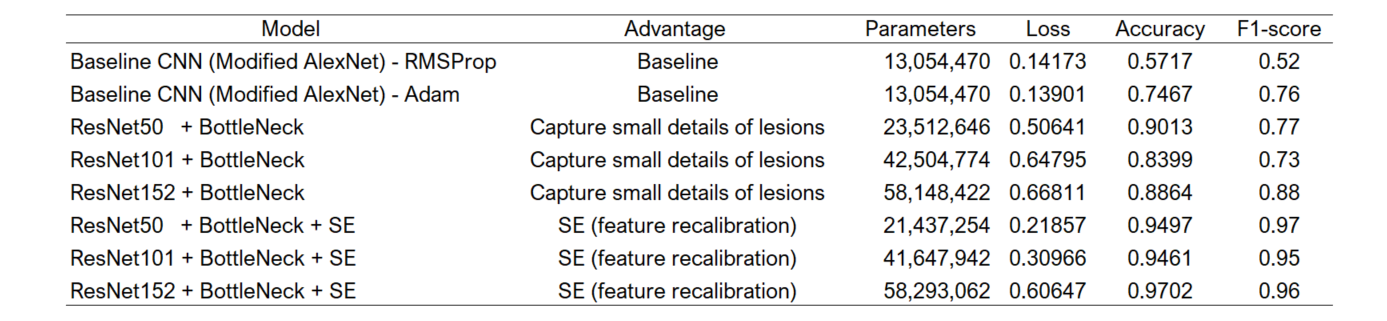

### D.1 Model Comparison to Testing Data

In this figure, we compared CNN Baseline to ResNet152+BottleNeck and ResNet152+BottleNeck+SEBlock for a single testing image for chickenpox and monkeypox cases. It is evident that SE block significantly boosts their feature recalibration, resulting in remarkably high F1-scores and accuracy, highlighting the efficacy of feature recalibration in enhancing classification performance.

*Other results can be found in the image folder.*

## References

- Ali, S. N., Ahmed, M. T., Jahan, T., Paul, J., Sani, S. M., Noor, N., ... & Hasan, T. (2023). A Web-based Mpox Skin Lesion Detection System Using State-of-the-art Deep Learning Models Considering Racial Diversity. arXiv preprint arXiv:2306.14169.
- He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).
- Hu, J., Shen, L., & Sun, G. (2018). Squeeze-and-excitation networks. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 7132-7141).
- Selvaraju, R. R., Das, A., Vedantam, R., Cogswell, M., Parikh, D., & Batra, D. (2016). Grad-CAM: Why did you say that?. arXiv preprint arXiv:1611.07450.
- Jamil, M. S., Banik, S. P., Rahaman, G. A., & Saha, S. (2023). Advanced GradCAM++: Improved Visual Explanations of CNN Decisions in Diabetic Retinopathy. In Computer Vision and Image Analysis for Industry 4.0 (pp. 64-75). 6000 Broken Sound Parkway NW, Suite 300, Boca Raton, FL 33487-2742: CRC Press.